## Model Calibration & Tuning - Defaults Data Set

### Model Tuning using probablity cut off

In [ ]:
#Data : https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,accuracy_score,brier_score_loss,f1_score,roc_auc_score, log_loss,roc_curve
import warnings
warnings.filterwarnings('ignore')

from sklearn.calibration import calibration_curve,CalibratedClassifierCV
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

%matplotlib inline

In [2]:
# Read input file and consider only the continous variables for now
data = pd.read_excel("defaults.xls", header=1)
model_features = list(set(data.columns).difference({"ID", "default payment next month", "SEX", "EDUCATION", "MARRIAGE"}))
target = ["default payment next month"]
X = data[model_features]
Y = data[target]

In [51]:
#Check the proportion of y class
Y.value_counts(normalize=True)*100

default payment next month
0                             77.88
1                             22.12
dtype: float64

In [3]:
#### Train Test Split  Ensure the stratified sample on the y variable
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,stratify=Y, random_state=123)

In [4]:
#Fit a basic RF model , class weight can be adjusted if imbalanced
rf_clf = RandomForestClassifier(n_estimators=100, 
                                max_depth=6, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight="balanced")
rf_clf.fit(X_train, y_train)
y_pred =  rf_clf.predict(X_test)
rf_predictions = rf_clf.predict_proba(X_test)
rf_roc_score = roc_auc_score(y_test, rf_predictions[:,1])
rf_roc_score

0.7781390504962772

In [5]:
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))

Accuracy Score 0.7738333333333334
Classification report:               precision    recall  f1-score   support

           0       0.88      0.82      0.85      4673
           1       0.49      0.61      0.54      1327

    accuracy                           0.77      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.77      0.78      6000

AUC: 0.7142425074636302


In [6]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_predictions[:,1])
thresholds

array([1.91521075, 0.91521075, 0.9147504 , ..., 0.20434183, 0.20413086,
       0.19950363])

In [7]:
# Determine the metric score based on the new thresholds
Metric_ls = []
for thres in thresholds:
    y_pred = np.where(rf_predictions[:,1]>thres,1,0)
    Metric_ls.append(f1_score(y_test, y_pred))
    
Metric_ls = pd.concat([pd.Series(thresholds), pd.Series(Metric_ls)],
                        axis=1)
Metric_ls.columns = ['thresholds', 'f1_score']
Metric_ls.sort_values(by='f1_score', ascending=False, inplace=True)
Metric_ls.head()

,thresholds,f1_score
671,0.527185,0.548084
667,0.527565,0.548025
669,0.527494,0.547955
672,0.526893,0.547886
670,0.527352,0.547757


In [8]:
threshold = 0.536939 # Use the best threshold as above here
preds = [1 if rf_predictions[i][1]> threshold else 0 for i in range(len(rf_predictions))]

In [9]:
print("Accuracy Score {}".format(accuracy_score(y_test,preds)))
print("Classification report: {}".format(classification_report(y_test,preds)))
print("AUC: {}".format(roc_auc_score(y_test, preds)))

Accuracy Score 0.7946666666666666
Classification report:               precision    recall  f1-score   support

           0       0.87      0.86      0.87      4673
           1       0.53      0.55      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.71      6000
weighted avg       0.80      0.79      0.80      6000

AUC: 0.7081921816408812


In [24]:
#Model Calibration using Platt
calib_clf = CalibratedClassifierCV(rf_clf,  method='isotonic', cv=3) #sigmoid or isotonic
calib_clf.fit(X_train, y_train)

calibrated_predictions = calib_clf.predict_proba(X_test)
calib_roc_score = roc_auc_score(y_test, calibrated_predictions[:,1])
calib_roc_score

0.7786681526465347

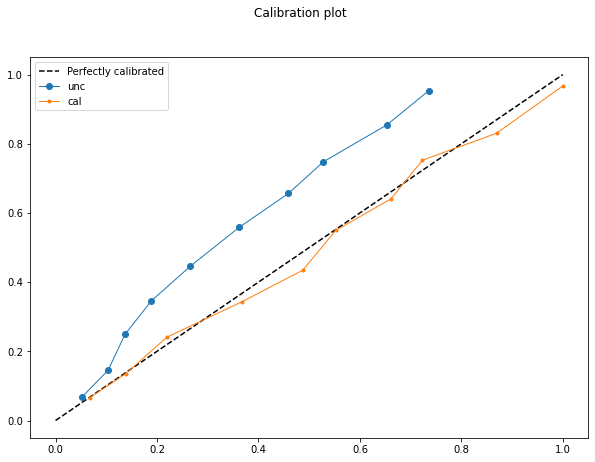

In [25]:
rf_y_unca, rf_x_unca = calibration_curve(y_test, rf_predictions[:,1], n_bins=10,normalize=True)
rf_y_cal, rf_x_cal = calibration_curve(y_test, calibrated_predictions[:,1], n_bins=10,normalize=True)

fig = plt.figure(figsize=(10, 7))

probablities = np.arange(0, 1.2, 0.2)

# plot perfectly calibrated
plt.plot(probablities, probablities, "--",color='black', label="Perfectly calibrated")

# plot model reliabilities
# only these two lines are calibration curves
plt.plot(rf_y_unca, rf_x_unca, marker='o', linewidth=1, label='unc')
# only these two lines are calibration curves
plt.plot(rf_y_cal, rf_x_cal, marker='.', linewidth=1, label='cal')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probs')
ax.set_ylabel('True Probs')

plt.legend(); 
plt.show()

In [26]:
# calculate bier score
print("Lower Bier Score is better")
print("Bier Score Before calibration: {}".format(round(brier_score_loss(y_test, rf_predictions[:,1], pos_label=1),3)))
print("Bier Score After calibration: {}".format(round(brier_score_loss(y_test,  calibrated_predictions[:,1], pos_label=1),3)))
print("")
print("Lower Log Loss is better")
print("Log Loss before calib: {}".format(round(log_loss(y_test,  rf_predictions[:,1], eps=1e-15, normalize=True),3)))
print("Log Loss after calib: {}".format(round(log_loss(y_test,  calibrated_predictions[:,1], eps=1e-15, normalize=True),3)))

Lower Bier Score is better
Bier Score Before calibration: 0.184
Bier Score After calibration: 0.135

Lower Log Loss is better
Log Loss before calib: 0.556
Log Loss after calib: 0.43


## Hyperparamter Tuning using Randomised SearchCV & GridSearchCV

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

In [28]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=20,cv=3,verbose=2, scoring = 'f1',
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 29.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, scoring='f1', verbose=2)

In [29]:
y_pred=rf_randomcv.best_estimator_.predict(X_test)
y_pred_prob=rf_randomcv.best_estimator_.predict_proba(X_test)[:, 1]  #Uses the second colum of array for 0/1
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))
print("Log Loss: {}".format(log_loss(y_test, y_pred_prob, eps=1e-15, normalize=True)))

[[4439  234]
 [ 840  487]]
Accuracy Score 0.821
Classification report:               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.68      0.37      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

AUC: 0.65845915971612
Log Loss: 0.4334223435640565


In [30]:
param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 80, rf_randomcv.best_params_['n_estimators'] - 50, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 50, rf_randomcv.best_params_['n_estimators'] + 80]
}


In [33]:
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=2,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 75 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.6min finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [670],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [12, 13, 14, 15, 16],
                         'n_estimators': [320, 350, 400, 450, 480]},
             verbose=2)

In [34]:
y_pred=grid_search.best_estimator_.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[4450  223]
 [ 846  481]]
Accuracy Score 0.8218333333333333
Classification report:               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.68      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.81      0.82      0.80      6000



In [52]:
calibrated = CalibratedClassifierCV(grid_search.best_estimator_, method='isotonic', cv=3)
calibrated.fit(X_train,y_train)

# predict probabilities
probs = calibrated.predict_proba(X_test)[:, 1]

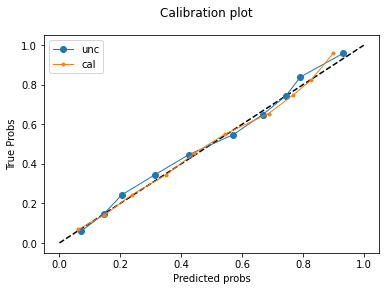

In [53]:
# reliability diagrams
rf_y_unca, rf_x_unca = calibration_curve(y_test, y_pred_prob, n_bins=10, normalize=True)
rf_y_cal, rf_x_cal = calibration_curve(y_test, probs, n_bins=10, normalize=True)

fig, ax = plt.subplots()

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')


# plot model reliabilities
# only these two lines are calibration curves
plt.plot(rf_y_unca, rf_x_unca, marker='o', linewidth=1, label='unc')
# only these two lines are calibration curves
plt.plot(rf_y_cal, rf_x_cal, marker='.', linewidth=1, label='cal')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probs')
ax.set_ylabel('True Probs')

plt.legend(); 
plt.show()

In [54]:
# calculate bier score
print("Before calibration: {}".format(round(brier_score_loss(y_test, y_pred_prob, pos_label=1),3)))
print("After calibration: {}".format(round(brier_score_loss(y_test, probs, pos_label=1),3)))
print("Log Loss before calib: {}".format(round(log_loss(y_test, y_pred_prob, eps=1e-15, normalize=True),3)))
print("Log Loss after calib: {}".format(round(log_loss(y_test, probs, eps=1e-15, normalize=True),3)))

Before calibration: 0.136
After calibration: 0.134
Log Loss before calib: 0.433
Log Loss after calib: 0.428
